## Neural Network training


We have prepared for you an extract of 3000 variant images for Genome in a Bottle NA12878 sample.
Half images are high-quality GiB variants, half images are sequencing artifacts.
The chosen variants are uniformly distributed on the whole genome length.

Having all this data, we are ready to train the neural network.

In [1]:
import pandas as pd
import numpy as np

In [2]:
#!cd {DATASET_DIR}; find . -name '*.img' -printf "%P\n" > {FILE_LIST} #generate the list of all variant images in the dataset

In [3]:
DATASET_ARCHIVE_PATH = 'data/dataset/tutorial_GiB.zip'

IMAGES_LIST = 'data/dataset/all_images_list' #relative paths to all images in the dataset archive

In [4]:
!head -n 5 {IMAGES_LIST}

germline/chr4_159690256.img
germline/chr3_109169659.img
germline/chr5_125338322.img
germline/chr7_134703331.img
germline/chr21_40192789.img


In [5]:
dataset_df = pd.read_csv(IMAGES_LIST, names=['relative_path']) # list of all images as pandas dataframe
dataset_df.head(5)

,relative_path
0,germline/chr4_159690256.img
1,germline/chr3_109169659.img
2,germline/chr5_125338322.img
3,germline/chr7_134703331.img
4,germline/chr21_40192789.img


<span style="color:red"> Now we need to add an extra column which should be 1 for germline variants and 0 for sequencing artifacts. How would one implement this? </span>

In [6]:
dataset_df['labels'] = dataset_df.apply(lambda x:int(x['relative_path'].startswith('germline')),axis=1) #label=1 if relative_path begins with 'germline'
dataset_df.head()

,relative_path,labels
0,germline/chr4_159690256.img,1
1,germline/chr3_109169659.img,1
2,germline/chr5_125338322.img,1
3,germline/chr7_134703331.img,1
4,germline/chr21_40192789.img,1


<span style="color:red"> Now let's split our dataset_df into train_df and val_df s.t. 90% of data goes to the train_df and the remaining 90% goes to val_df. How can this be implemented?  </span>

In [7]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=9, shuffle=True, random_state=1) #9 splits --> 10% of examples goes to validation set

placeholder = np.ones((len(dataset_df),1)) #placeholder of length equal to the number of samples

images_labels = dataset_df['labels'].tolist()

skf.get_n_splits(placeholder, images_labels)

idx_train, idx_test = list(skf.split(placeholder, images_labels))[0] #take the 0th fold

train_df = dataset_df.iloc[idx_train] 

val_df = dataset_df.iloc[idx_test] 

In [8]:
#Print the class distribution in train and validation datasets

print('Train dataframe class counts:')
print(train_df['labels'].value_counts())
print()
print('Validation dataframe class counts:')
val_df['labels'].value_counts()

Train dataframe class counts:
0    1333
1    1333
Name: labels, dtype: int64

Validation dataframe class counts:


0    167
1    167
Name: labels, dtype: int64

In [9]:
train_df

,relative_path,labels
2,germline/chr5_125338322.img,1
3,germline/chr7_134703331.img,1
4,germline/chr21_40192789.img,1
5,germline/chr2_126513701.img,1
6,germline/chr18_63578873.img,1
...,...,...
2995,negative/chr13_79255988.img,0
2996,negative/chr12_123816211.img,0
2997,negative/chr16_47496816.img,0
2998,negative/chrX_140444033.img,0


<span style="color:red"> What's wrong with our train dataframe? How to change this? </span>

In [10]:
train_df = train_df.sample(frac=1, random_state=1)
train_df.head()

,relative_path,labels
1697,negative/chr2_235329604.img,0
312,germline/chr2_208500922.img,1
698,germline/chr2_107581433.img,1
2056,negative/chr17_59015327.img,0
2207,negative/chr7_142470336.img,0


In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
import zipfile

dataset_archive = zipfile.ZipFile(DATASET_ARCHIVE_PATH, 'r') #open the archive with all variant images in the dataset

class Dataset(Dataset):
    
    '''
    Dataset of variant images
    '''

    def __init__(self, 
                 data,           #relative path to images with corresponding labels
                 target_height,  #target image height for the neural network
                ):

        self.data = data
        self.target_height = target_height
        
    def __len__(self):

        return len(self.data)

    def __getitem__(self, idx):
        
        '''
        Retrive an image
                
        If image height is smaller than self.target_height,
        we pad it with "N" to reach the required self.target_height.
        If image height is larger that self.target_height,
        we remove some reads on the top and on the bottom, leaving the central part.
        
        The original image is then shifted to the center of this new full image.
        '''
        
        relative_image_path, label = self.data[idx]
        
        #full_image_path = self.dataset_dir+relative_image_path
        #with open(full_image_path, 'rb') as imgfile:
        #        image = pickle.load(imgfile)

        imgfile = dataset_archive.open(relative_image_path) #open image file directly out of the archive
        image = pickle.load(imgfile)                #load pickle data from the image file
            
        one_hot_ref = image['one_hot_ref']      #one-hot encoding of reference bases
        p_hot_reads = image['p_hot_reads']*1e-4 #p-hot encoding of reads bases
        flags_reads = image['flags_reads']      #flags for reads
            
        image_height, image_width, _ = p_hot_reads.shape
                  
        one_hot_ref = np.tile(one_hot_ref, (image_height,1,1)) #propagate reference bases over all reads
            
        image = np.concatenate((one_hot_ref,p_hot_reads,flags_reads), axis=2)

        if self.target_height>image_height:
            #pad image with 'N' to reach the target height
            padding_image = np.concatenate(
                    (np.tile(one_hot_ref[0,:,:],(self.target_height-image_height,1,1)), #4 channels for reference bases, should be the same as in the reads
                    np.ones((self.target_height-image_height, image_width, 4))*0.25,    #p-hot encoding for 'N'
                    np.zeros((self.target_height-image_height, image_width, 6))         #read flags
                    ), 
                    axis=2)
            
            full_image = np.concatenate((image, padding_image), axis = 0) #concatenate over the reads axis
            full_image = np.roll(full_image,max(self.target_height//2-image_height//2,0),axis=0) #put the piledup reads in the center of image

        else:
            #if there are too many reads, keep reads in the center, remove at the top and at the bottom
            shift = max(image_height//2-self.target_height//2,0)
            full_image = image[shift:shift+self.target_height,:,:]
                
        full_image = np.transpose(full_image, (2,0,1)) #change dimensions order to CxWxH

        return full_image, label

In [22]:
#define train and validation datasets

train_dataset = Dataset(train_df.values.tolist(), target_height=70)

val_dataset = Dataset(val_df.values.tolist(), target_height=70)

#define train and validation dataloaders

train_dataloader = DataLoader(train_dataset, batch_size=96, shuffle=False, num_workers=0)

val_dataloader = DataLoader(val_dataset, batch_size=96, shuffle=False, num_workers=0)

In [23]:
#define the neural network architecture

class ConvNN(nn.Module):
    
    def __init__(self, dropout=0.):

        super().__init__()

        #150x70

        self.conv1 = nn.Conv2d(14, 32, kernel_size=5, stride=1, padding=0) #146x66
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.dp1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0) #142x62
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.dp2 = nn.Dropout(dropout)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)#71x31x64

        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=0)#67x27
        self.bn3 = nn.BatchNorm2d(64)
        self.act3 = nn.ReLU()
        self.dp3 = nn.Dropout(dropout)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)#33x13

        self.conv4 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=0)#29x9
        self.bn4 = nn.BatchNorm2d(64)
        self.act4 = nn.ReLU()
        self.dp4 = nn.Dropout(dropout)
        self.mp4 = nn.MaxPool2d(kernel_size=2, stride=2)#14x4

        self.flt = nn.Flatten()

        self.fc5 = nn.Linear(14 * 4 * 64, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.act5 = nn.ReLU()
        self.dp5 = nn.Dropout(dropout)

        self.fc6 = nn.Linear(64, 1)
        self.act6 = nn.Sigmoid()


    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.dp1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.act2(out)
        out = self.dp2(out)
        out = self.mp2(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.act3(out)
        out = self.dp3(out)
        out = self.mp3(out)

        out = self.conv4(out)
        out = self.bn4(out)
        out = self.act4(out)
        out = self.dp4(out)
        out = self.mp4(out)

        out = self.flt(out)

        out = self.fc5(out)
        out = self.bn5(out)
        out = self.act5(out)
        out = self.dp5(out)

        out = self.fc6(out)
        out = self.act6(out)
        
        out = torch.squeeze(out)

        return out

In [24]:
#get access to GPU

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('\nCUDA device: GPU\n')
else:
    device = torch.device('cpu')
    print('\nCUDA device: CPU\n')


CUDA device: GPU



In [25]:
model = ConvNN(dropout=0.2) #create the model

model = model.to(device)    #model to CUDA

model_params = [p for p in model.parameters() if p.requires_grad] #model parameters for optimizer

In [26]:
#show the model architecture

from torchsummary import summary
summary(model,(14,150,70), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 32, 146, 66]          11,232
       BatchNorm2d-2          [64, 32, 146, 66]              64
              ReLU-3          [64, 32, 146, 66]               0
           Dropout-4          [64, 32, 146, 66]               0
            Conv2d-5          [64, 64, 142, 62]          51,264
       BatchNorm2d-6          [64, 64, 142, 62]             128
              ReLU-7          [64, 64, 142, 62]               0
           Dropout-8          [64, 64, 142, 62]               0
         MaxPool2d-9           [64, 64, 71, 31]               0
           Conv2d-10           [64, 64, 67, 27]         102,464
      BatchNorm2d-11           [64, 64, 67, 27]             128
             ReLU-12           [64, 64, 67, 27]               0
          Dropout-13           [64, 64, 67, 27]               0
        MaxPool2d-14           [64, 64,

In [27]:
optimizer = torch.optim.AdamW(model_params, lr=2e-3)

<span style="color:red"> We shall implement a function to train the model. What loss function should we choose ? </span>

In [28]:
from tqdm.notebook import tqdm

def train(model, dataloader):
    
    model.train() #model to train mode
   
    criterion = nn.BCELoss() #binary cross-entropy
    
    tot_itr = len(dataloader.dataset.data)//dataloader.batch_size #total train iterations
    
    pbar = tqdm(total = tot_itr, ncols=700) #progress bar
    
    beta = 0.98 #beta of running average, don't change
    
    avg_loss = 0. #average loss
    
    for itr_idx, (images, labels) in enumerate(dataloader):
        
        images = images.to(torch.float).to(device) #images to torch.float32 then to GPU
        labels = labels.to(torch.float).to(device) #labels to torch.float32 then to GPU

        outputs = model(images)
        
        loss = criterion(outputs, labels) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #exponential moving evaraging of loss
        avg_loss = beta * avg_loss + (1-beta)*loss.item()
        smoothed_loss = avg_loss / (1 - beta**(itr_idx+1))
 
        pbar.update(1)
        pbar.set_description(f"Running loss:{smoothed_loss:.4}")
        
    return smoothed_loss
        
train(model, train_dataloader);

  0%|                                                                                                         …

In [29]:
def validate(model, dataloader):
    
    model.eval() #model to validation mode
   
    criterion = nn.BCELoss() #binary cross-entropy
    
    tot_itr = len(dataloader.dataset.data)//dataloader.batch_size #total validation iterations
    
    pbar = tqdm(total = tot_itr, ncols=700) #progress bar
    
    all_loss = 0. #all losses, for simple averaging
    
    all_preds = [] #all validation predictions
    
    with torch.no_grad():

        for itr_idx, (images, labels) in enumerate(dataloader):
        
            images = images.to(torch.float).to(device) #images to torch.float32 then to GPU
            labels = labels.to(torch.float).to(device) #labels to torch.float32 then to GPU

            outputs = model(images)
            loss = criterion(outputs, labels) 

            all_loss += loss.item()
            
            all_preds.extend(list(zip(outputs.cpu().numpy(), labels.cpu().numpy())))
             
            pbar.update(1)
            pbar.set_description(f"Running loss:{all_loss/(itr_idx+1):.4}")
        
    return all_loss/(itr_idx+1), all_preds #return average loss and predictions

val_loss, val_preds = validate(model, val_dataloader)

  0%|                                                                                                         …

<span style="color:red"> By the way, why do we use exponential moving averaging for training and simple aberaging during validation ? </span>

In [30]:
#Compute precision-recall curve and get the maximum f1-score

from sklearn.metrics import precision_recall_curve
    
outputs, labels = list(zip(*val_preds))

all_precision, all_recall, thresholds = precision_recall_curve(labels, outputs)

f1 = 2*all_precision*all_recall/(all_precision+all_recall+1e-10)

best_f1 = max(f1)

best_f1_index = np.nanargmax(f1) #index of the maximal f1-score to get the corresponding precision and recall

print(f'Maximal f1-score {best_f1:.2} is reached with precision {all_precision[best_f1_index]:.2} and recall {all_recall[best_f1_index]:.2}')

Maximal f1-score 0.83 is reached with precision 0.82 and recall 0.84


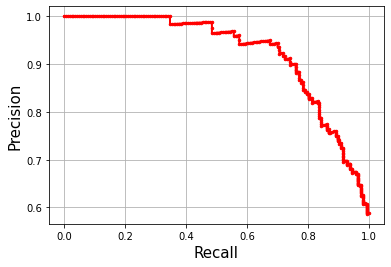

In [31]:
#Plot precision-recall curve

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(all_recall, all_precision, 'r-', lw=2, marker = '.', markersize = 5)
plt.grid()
plt.ylabel('Precision', fontsize=15)
plt.xlabel('Recall', fontsize=15);

<span style="color:red"> In our train set we had the class proportion true:false = 1:1. For an actual GiB NA12878 sample the class proportion is true:false = 1:2. Do we have to do anything with this class imbalance and if we do then what? </span>